# Entendimiento del negocio

**Proyecto:** Allianz Vehicle Insurance Claim Prediction
**Autor:** Juan Carlos Baez Lizarazo

## 1.1 Introducción

En la industria de seguros, predecir con precisión la probabilidad de reclamos es esencial para la evaluación de riesgos y la fijación de precios de las pólizas. Sin embargo, los conjuntos de datos de reclamos de seguros frecuentemente sufren de desequilibrio de clases, donde el número de instancias sin reclamos supera con creces al de reclamos reales. Este desequilibrio de clases plantea desafíos para el modelado predictivo, a menudo llevando a modelos sesgados que favorecen la clase mayoritaria, lo que resulta en un rendimiento inferior para la clase minoritaria, que típicamente es de mayor interés.

## 1.2 Objetivo del negocio

El objetivo principal es desarrollar un modelo de **Scoring de Riesgo** que estime la probabilidad de que un asegurado realice un reclamo (`claim_status`).
Esto permitirá a la compañía:
1.  **Optimizar tasas:** Cobrar primas más justas basadas en el riesgo real.
2.  **Mejorar el perfilamiento:** Identificar perfiles de alto riesgo antes de emitir la póliza.

## 1.3 Definición de campos
El [dataset](../data/Claims%20Dataset.csv) contiene información técnica del cliente, del vehículo (propia, de seguridad, equipamiento adicional) y estado de la póliza. A continuación, se detalla cada campo:

### 1. Datos del cliente

| Variable | Descripción | Tipo Dato | Ejemplo |
| -------- | ----------- | --------- | ------- |
| policy_id | Identificador único de la póliza. | str | POL045360 |
| subscription_length | Antigüedad del cliente con la aseguradora. | float | 9.3 |
| vehicle_age | Antigüedad del vehiculo asegurado. | float | 1.2 |
| customer_age | Edad del titular de la póliza. | int | 41 |
| region_code | Código representativo de la región geografica del titular de la póliza. | cat | C8 |
| region_density | Densidad poblacional de la región. Más densidad suele implicar más frecuencia de choques leves. | int | 8794 |

### 2. Especificaciones del Vehículo
| Variable | Descripción | Tipo Dato | Ejemplo |
| -------- | ----------- | --------- | ------- |
| segment | Segmento comercial del auto (A, B, C, SUV, etc.). | cat | C2 |
| model | Código del modelo del vehículo asegurado. | cat | M4 |
| fuel_type | Tipo de combustible que usa el vehículo. | cat | Diesel |
| max_torque | Fuerza máxima del motor (Newton-metro @ RPM). | str | 250Nm@2750rpm |
| max_power | Potencia máxima (Caballos de fuerza @ RPM). | str | 113.45bhp@4000rpm |
| engine_type | Denominación técnica del motor. | str | 1.5 L U2 CRDi |
| displacement | Cilindrada del motor en cc (centímetros cúbicos). | int | 1493 |
| cylinder | Número de cilindros | int | 4 |
| transmission_type | Manual o Automático. | cat | Automatic |
| gross_weight | Peso bruto del vehículo (kg). | int | 1720 |

### 3. Seguridad y equipamiento del Vehículo
| Variable | Descripción | Tipo Dato | Ejemplo |
| -------- | ----------- | --------- | ------- |
| ncap_rating | Calificación de seguridad oficial (0 a 5 estrellas). | int | 3 |
| airbags | Cantidad de airbags. | int | 6 |
| is_esc | Control Electrónico de Estabilidad. Evita derrapes. | boolean | yes |
| is_brake_assist | Asistente de frenado de emergencia. | boolean | yes |
| is_tpms | Sistema de monitoreo de presión de llantas. | boolean | yes |
| is_speed_alert | Alerta de exceso de velocidad. | boolean | yes |
| rear_brakes_type | Tipo de frenos traseros (Disco vs Tambor). | cat | Disc |
| is_parking_sensors | Sensores de parqueo. | boolean | yes |
| is_parking_camera | Cámara de reversa. | boolean | yes |
| is_power_steering | Dirección asistida. | boolean | yes |
| is_day_night_rear_view_mirror | Espejo retrovisor electrocrómico. | boolean | yes |
| is_ecw | Característica desconocida asociada a factores de riesgo. | boolean | yes |

### 4. Variable objetivo
| Variable | Descripción | Tipo Dato | Ejemplo |
| -------- | ----------- | --------- | ------- |
| claim_status | Variable a predecir. 0: No realizó reclamo en el periodo. 1: Sí realizó reclamo. | boolean | 0 |


In [21]:
# imports
from pathlib import Path

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, train_test_split

In [2]:
# global configuration
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)
plt.style.use("ggplot")

In [6]:
# Routes
DATA_PATH = Path("../data")
RAW_DATA_FILE = DATA_PATH / "raw" / "claims_dataset.csv"
PROCESSED_DATA_PATH = DATA_PATH / "processed"

In [4]:
# Seed for reproducibility
SEED = 42

In [7]:
# Load dataset
try:
    df = pd.read_csv(RAW_DATA_FILE, sep=";")
    print(f"Dataset loaded successfully. Dimensions: {df.shape}")
except FileNotFoundError:
    print("Error! The file does not exist. Check the path.")

# Initial overview
df.head()

Dataset loaded successfully. Dimensions: (58592, 41)


,policy_id,subscription_length,vehicle_age,customer_age,region_code,region_density,segment,model,fuel_type,max_torque,max_power,engine_type,airbags,is_esc,is_adjustable_steering,is_tpms,is_parking_sensors,is_parking_camera,rear_brakes_type,displacement,cylinder,transmission_type,steering_type,turning_radius,length,width,gross_weight,is_front_fog_lights,is_rear_window_wiper,is_rear_window_washer,is_rear_window_defogger,is_brake_assist,is_power_door_locks,is_central_locking,is_power_steering,is_driver_seat_height_adjustable,is_day_night_rear_view_mirror,is_ecw,is_speed_alert,ncap_rating,claim_status
0,POL045360,9.3,1.2,41,C8,8794,C2,M4,Diesel,250Nm@2750rpm,113.45bhp@4000rpm,1.5 L U2 CRDi,6,Yes,Yes,Yes,Yes,Yes,Disc,1493,4,Automatic,Power,5.2,4300,1790,1720,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,3,0
1,POL016745,8.2,1.8,35,C2,27003,C1,M9,Diesel,200Nm@1750rpm,97.89bhp@3600rpm,i-DTEC,2,No,Yes,No,Yes,Yes,Drum,1498,4,Manual,Electric,4.9,3995,1695,1051,Yes,No,No,Yes,No,Yes,Yes,Yes,Yes,Yes,Yes,Yes,4,0
2,POL007194,9.5,0.2,44,C8,8794,C2,M4,Diesel,250Nm@2750rpm,113.45bhp@4000rpm,1.5 L U2 CRDi,6,Yes,Yes,Yes,Yes,Yes,Disc,1493,4,Automatic,Power,5.2,4300,1790,1720,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes,No,Yes,Yes,3,0
3,POL018146,5.2,0.4,44,C10,73430,A,M1,CNG,60Nm@3500rpm,40.36bhp@6000rpm,F8D Petrol Engine,2,No,No,No,Yes,No,Drum,796,3,Manual,Power,4.6,3445,1515,1185,No,No,No,No,No,No,No,Yes,No,No,No,Yes,0,0
4,POL049011,10.1,1.0,56,C13,5410,B2,M5,Diesel,200Nm@3000rpm,88.77bhp@4000rpm,1.5 Turbocharged Revotorq,2,No,Yes,No,Yes,No,Drum,1497,4,Manual,Electric,5.0,3990,1755,1490,No,No,No,No,No,Yes,Yes,Yes,No,No,Yes,Yes,5,0


Integrity check passed: All policy_id are unique.

Target Variable Distribution (Claim Status):
claim_status
0    93.603222
1     6.396778
Name: proportion, dtype: float64


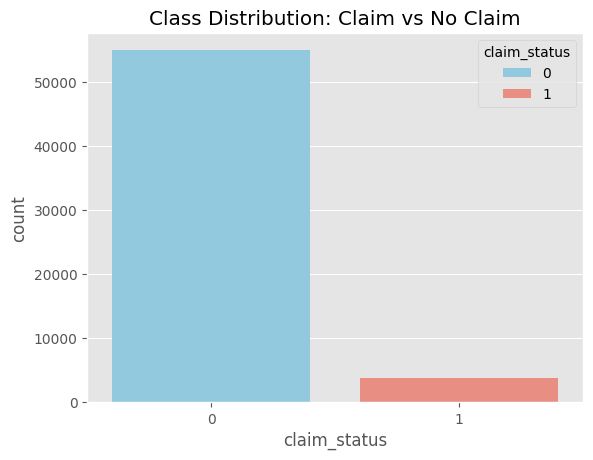

In [8]:
# 1. verify Data Integrity (Unique Identifiers)
if df["policy_id"].duplicated().any():
    print(f"¡ALERT! {df['policy_id'].duplicated().sum()} duplicated policies found.")
else:
    print("Integrity check passed: All policy_id are unique.")

# 2. Check Target Variable Distribution
claim_dist = df["claim_status"].value_counts(normalize=True) * 100
print("\nTarget Variable Distribution (Claim Status):")
print(claim_dist)

# Plot distribution
sns.countplot(
    x="claim_status", data=df, palette=["skyblue", "salmon"], hue="claim_status"
)
plt.title("Class Distribution: Claim vs No Claim")
plt.show()

## 1.4 Clase desbalanceada

Se observa un desbalance de clase muy fuerte, por lo que en este caso podemos definir que para este modelo debemos ajustarlo siguiendo la métrica de AUC-ROC o recall, puesto que usar una métrica como un accuracy nos dara un resultado falso por la cantidad de no reclamos que existen.

In [9]:
# Data type
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 58592 entries, 0 to 58591
Data columns (total 41 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   policy_id                         58592 non-null  str    
 1   subscription_length               58592 non-null  float64
 2   vehicle_age                       58592 non-null  float64
 3   customer_age                      58592 non-null  int64  
 4   region_code                       58592 non-null  str    
 5   region_density                    58592 non-null  int64  
 6   segment                           58592 non-null  str    
 7   model                             58592 non-null  str    
 8   fuel_type                         58592 non-null  str    
 9   max_torque                        58592 non-null  str    
 10  max_power                         58592 non-null  str    
 11  engine_type                       58592 non-null  str    
 12  airbags        

## 1.5 Datos nulos

Vemos que no existen nulos en nuestro dataset, lo quees bueno para no recurrir a tecnicas de limpieza o imputacion en columnas de alto valor.

In [ ]:
# 1. split features and target
X = df.drop(["claim_status"], axis=1)
y = df["claim_status"]

# 2. Create the Final Test Set (20%)
X_train_full, X_test, y_train_full, y_test = train_test_split(
    X, y, test_size=0.2, random_state=SEED, stratify=y
)

# 3. Prepare the Full Training DataFrame
train_df = pd.concat([X_train_full, y_train_full], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

# Reset index for both sets
train_df = train_df.reset_index(drop=True)

# 4. Create Stratified K-Folds in the Training Set
# Initialize the column to -1
train_df["kfold"] = -1

# Initialize StratifiedKFold
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

# Fill the 'kfold' column
for fold, (_train_idx, val_idx) in enumerate(
    kf.split(X=train_df, y=train_df["claim_status"])
):
    train_df.loc[val_idx, "kfold"] = fold

# 5. Summary of the splits
print("General Dimensions:")
print(f"-> Train Set (for CV): {train_df.shape[0]} rows (80%)")
print(f"-> Test Set (Hold-out): {test_df.shape[0]} rows (20%)")

print("\nDistribution of Folds in Train Set:")
print(train_df.kfold.value_counts())

# 6. Save the files
PROCESSED_DATA_PATH.mkdir(parents=True, exist_ok=True)

# Save the train set with the folds column and the clean test set
train_df.to_csv(PROCESSED_DATA_PATH / "train_folds.csv", index=False)
test_df.to_csv(PROCESSED_DATA_PATH / "test.csv", index=False)

General Dimensions:
-> Train Set (for CV): 46873 rows (80%)
-> Test Set (Hold-out): 11719 rows (20%)

Distribution of Folds in Train Set:
kfold
2    9375
1    9375
0    9375
3    9374
4    9374
Name: count, dtype: int64


## 1.6 Benchmark Base

A continuación se realizará un modelo que siempre va a predecir que no hay reclamo, con esto concluir riesgos base de construir un modelo que no sepa diferenciar esos casos aislados de reclamos y poner una linea base para que nuestra solución superé estos números para ser útil en producción.

--- BASELINE PERFORMANCE ---
              precision    recall  f1-score   support

           0       0.94      1.00      0.97     10969
           1       0.00      0.00      0.00       750

    accuracy                           0.94     11719
   macro avg       0.47      0.50      0.48     11719
weighted avg       0.88      0.94      0.91     11719

Baseline AUC-ROC: 0.5000
Lift @ Top 10%: 0.8940


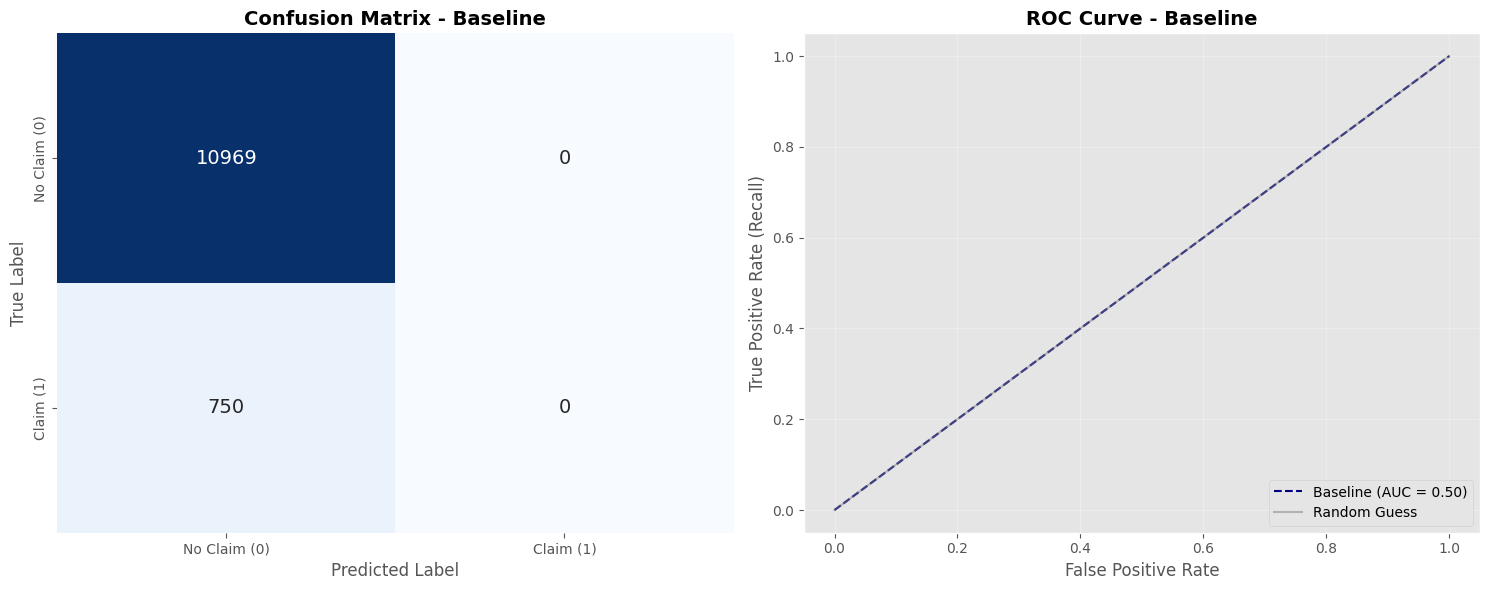

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.dummy import DummyClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
)


def calculate_lift(y_true, y_proba, percentile=10):
    """
    Calculate the lift at a given percentile.
    Formula: Lift = (Target Rate in Top X%) / (Overall Target Rate)
    """
    data = pd.DataFrame({"y_true": y_true, "proba": y_proba})
    data = data.sort_values("proba", ascending=False)

    cut_off = int(len(data) * (percentile / 100))

    top_data = data.iloc[:cut_off]

    target_rate_top = top_data["y_true"].mean()
    target_rate_global = data["y_true"].mean()

    if target_rate_global == 0:
        return 0

    return target_rate_top / target_rate_global


# 1. configure and train Dummy Classifier
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train_full, y_train_full)

# 2. Predict on test set
y_test_pred_dummy = dummy_clf.predict(X_test)
y_test_proba_dummy = dummy_clf.predict_proba(X_test)[:, 1]

# 3. Evaluate performance
print("--- BASELINE PERFORMANCE ---")
print(classification_report(y_test, y_test_pred_dummy, zero_division=0))
auc_score = roc_auc_score(y_test, y_test_proba_dummy)
print(f"Baseline AUC-ROC: {auc_score:.4f}")
lift_score = calculate_lift(y_test, y_test_proba_dummy, percentile=10)
print(f"Lift @ Top 10%: {lift_score:.4f}")

# 4. Visualizations
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_test_pred_dummy)

# Heatmap with annotations
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues", cbar=False, ax=ax[0], annot_kws={"size": 14}
)
ax[0].set_title("Confusion Matrix - Baseline", fontsize=14, fontweight="bold")
ax[0].set_xlabel("Predicted Label", fontsize=12)
ax[0].set_ylabel("True Label", fontsize=12)
ax[0].set_xticklabels(["No Claim (0)", "Claim (1)"])
ax[0].set_yticklabels(["No Claim (0)", "Claim (1)"])

# Calculate ROC curve points
fpr, tpr, thresholds = roc_curve(y_test, y_test_proba_dummy)

# Plot
ax[1].plot(
    fpr, tpr, linestyle="--", color="navy", label=f"Baseline (AUC = {auc_score:.2f})"
)
ax[1].plot([0, 1], [0, 1], color="gray", linestyle="-", alpha=0.5, label="Random Guess")

ax[1].set_title("ROC Curve - Baseline", fontsize=14, fontweight="bold")
ax[1].set_xlabel("False Positive Rate", fontsize=12)
ax[1].set_ylabel("True Positive Rate (Recall)", fontsize=12)
ax[1].legend(loc="lower right")
ax[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 1.7 Conclusiones

Alineados con el objetivo estratégico y el contexto del negocio, la prioridad es optimizar la capacidad de detección de reclamos. Para ello, hemos definido una estrategia de balance entre cobertura y precisión:

1.  **Priorización del Recall (Sensibilidad):** Nuestro objetivo es alcanzar un **Recall del 60%** en la clase positiva (reclamos). Si bien matemáticamente es deseable maximizar este valor, en el contexto de seguros existe un *trade-off* crítico: un modelo demasiado sensible (o "ácido") generaría un exceso de Falsos Positivos. Esto implicaría calcular valores altos a clientes de bajo riesgo, afectando la competitividad de nuestros precios y provocando la pérdida de clientes (churn). El umbral del 60% nos permite detectar la mayoría de los siniestros sin sacrificar la viabilidad comercial.
2.  **Calidad de la Discriminación (ROC-AUC):** Para mitigar el riesgo de precios incorrectos, utilizaremos el **ROC-AUC** como medida de robustez, buscando un valor superior a **0.75**. Esto garantiza que el modelo tenga la capacidad suficiente para ordenar correctamente a los clientes según su nivel de riesgo (scoring), permitiendo una segmentación tarifaria fiable.
3.  **Efectividad en la Segmentación (Lift):** Dado que la tasa base de reclamos es baja (6.4%), validaremos la efectividad del modelo mediante el **Lift en el top 10%**. Exigiremos que el decil identificado como de "mayor riesgo" concentre una siniestralidad al menos **3 veces superior** a la media poblacional. Esto asegura que el modelo está agrupando efectivamente los casos críticos en la parte superior de la distribución.

## 1.8 Definición de KPIs de Éxito del Proyecto (Business Objectives)

Considerando el desbalance de clases (6.4% de tasa de eventos) y partiendo de un benchmark aleatorio (AUC 0.5), se establecen los siguientes criterios estrictos de aceptación para el paso a producción:

| KPI | Métrica Técnica | Meta Mínima (MVP) | Justificación de Negocio |
| :--- | :--- | :--- | :--- |
| **Capacidad de Discriminación** | `ROC-AUC Score` | **> 0.75** | Garantiza la fiabilidad para crear *Tiers* (niveles) de precios diferenciados. Un valor inferior implica un alto riesgo de tarifación errónea (sub-cobro o sobre-cobro). |
| **Cobertura de Riesgo** | `Recall` (Sensibilidad) | **> 60%** | Asegura la detección de la mayoría de la siniestralidad para ajustar correctamente las reservas técnicas, manteniendo un margen tolerable de Falsos Positivos. |
| **Eficiencia de Captación** | `Lift @ Top 10%` | **> 3.0x** | Valida el poder predictivo en el segmento crítico: el grupo clasificado como "Más Riesgoso" debe tener una densidad de siniestros 3 veces mayor al promedio de la cartera. |

## 1.9 Estrategia de Validación y Robustez del Modelo

Para garantizar que los KPIs definidos anteriormente sean sostenibles en un entorno productivo y mitigar el riesgo de sobreajuste (*overfitting*), se implementará un protocolo de validación riguroso que simula condiciones reales de operación:

1.  **Validación Cruzada Estratificada (Fold Stratified Cross-Validation):**
    Dado que contamos con un total aproximado de 3,750 casos de reclamo (6.4% de la muestra), un particionamiento simple dejaría muy pocos casos para la evaluación final, aumentando la varianza de los resultados.
    Por ello, aplicaremos una validación cruzada estratificada. Dividiremos los datos en 5 subconjuntos, asegurando que el modelo sea entrenado y validado rotativamente sobre la totalidad de la base de datos. Esto nos permite promediar el rendimiento y asegurar que las métricas de **Recall** y **Lift** son estables independientemente del subconjunto de datos utilizado.

2.  **Control de Brecha de Rendimiento (Train-Test Gap):**
    Se establecerá un umbral máximo de tolerancia para la divergencia entre las métricas de entrenamiento y validación. Una diferencia superior al **3-5%** en el ROC-AUC entre el set de *Train* y el de *Test* será considerada una señal de alerta de *overfitting*, activando procesos de regularización (simplificación del modelo, selección de características más robustas o ajuste de hiperparámetros) antes de cualquier paso a producción.